In [1]:
import pyam
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.transforms as mtransforms
from matplotlib.container import ErrorbarContainer
from matplotlib.collections import LineCollection

from pathlib import Path

<IPython.core.display.Javascript object>

Step 1: Read in the necessary data from the notebook `101_prepare_input_data.ipynb`

In [2]:
df = pyam.IamDataFrame(
    Path(
        '../data/101_data.xlsx'
    )
)

pyam - INFO: Running in a notebook, setting up a basic logging at level INFO
pyam.core - INFO: Reading file ../data/101_data.xlsx
pyam.core - INFO: Reading meta indicators


In [3]:
delay_categpries = pd.read_excel(
    Path(
        '../data/103_delay_categories.xlsx'
    ),
    index_col=[0,1]
)

Step 2: Pull put the CDR variables.

In [4]:
cdr_variables = [
    x for x in df.variable if 'Carbon Removal' in x
]
cdr_variables

['AR6 Reanalysis|OSCARv3.2|Carbon Removal',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Direct',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Indirect',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Non-Land',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Total']

In [5]:
df_cdr = (
    df
    .filter(
        variable=cdr_variables,
        region='World'
    )
)

In [6]:
df_wo_cdr = (
    df
    .filter(
        variable=set(df.variable) - set(cdr_variables),
        region='World'
    )
)

Step 3: Convert the unit for CDR to ensure we get a consistent estimate.

In [7]:
df_cdr.convert_unit(
    current='Gt CO2/yr',
    to='Gt CO2/yr',
    factor=-1,
    inplace=True
)

Step 4: Filter the necessary variables for the assessment.

In [8]:
variables = [
    'AR6 Reanalysis|OSCARv3.2|Emissions|Kyoto Gases|Direct Only',
    'AR6 Reanalysis|OSCARv3.2|Emissions|NonCO2|Direct Only',
    'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Gross',
    'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Direct Only'
]

In [9]:
df_wo_cdr.filter(
    variable=variables,
    inplace=True
)

Step 5: Compile the necessary data for our assessment

In [10]:
compiled_data_magnitude = pyam.concat(
    [
        df_cdr,
        df_wo_cdr
    ]
)

In [11]:
compiled_data_magnitude.filter(
    year=range(2020, 2101),
    inplace=True
)

Step 6: Calculate the offset from 2020.

In [12]:
compiled_data_magnitude_offset = (
    compiled_data_magnitude
    .offset(year=2020)
)

Step 7: Pull out the total mitigatio effort.

In [13]:
total_mitigation_effort = 'AR6 Reanalysis|OSCARv3.2|Emissions|Kyoto Gases|Direct Only'

In [14]:
total_mitigation = (
    compiled_data_magnitude
    .filter(
        variable=total_mitigation_effort,
        region='World'
    )
    .timeseries()
    .reset_index()
    .drop(
        columns=[
            'variable',
            'region',
            'unit'
        ]
    )
    .set_index(
        [
            'model',
            'scenario'
        ]
    )
)

In [15]:
netzero_co2 = 'Year of netzero CO2 emissions (Harm-Infilled) table'
netzero_ghg = 'Year of netzero GHG emissions (Harm-Infilled) table'

In [16]:
compiled_data_magnitude_offset.meta = compiled_data_magnitude.meta

Step 8: Read in the delay categories. This will be important for panel b and c of the figure.

In [17]:
delay_categories = pd.read_excel(
    Path(
        '../data/103_delay_categories.xlsx'
    ),
    index_col=[0,1]
)

In [18]:
panel_bc = pd.concat(
    [
        compiled_data_magnitude.meta,
        delay_categories
    ],
    axis=1
)

In [19]:
panel_bc['category_reductions'] = panel_bc['category_reductions'].astype('category')
panel_bc['category_netzero'] = panel_bc['category_netzero'].astype('category')

Step 9: Pull out the necessary data for panel d.
First, we need the cumulative non CO2 reductions from the year of net zero CO2 to 2100.

In [20]:
compiled_data_magnitude.meta.loc[:, netzero_co2] = compiled_data_magnitude.meta.loc[:, netzero_co2].fillna(2100)

In [21]:
nonco2 = (
    compiled_data_magnitude
    .filter(
        variable='AR6 Reanalysis|OSCARv3.2|Emissions|NonCO2|Direct Only'
    )
    .timeseries()
)

In [22]:
netzero_co2[0]

'Y'

In [23]:
compiled_data_magnitude.set_meta(
    meta=nonco2.apply(
        lambda x: pyam.cumulative(
            x,
            first_year=compiled_data_magnitude.meta.loc[x.name[0:2], netzero_co2],
            last_year=2100
        ),
        axis=1
    ),
    name='cumulative_nonco2_netzero_2100'
)

Step 10: Compile the elements used in panel d.

In [24]:
panel_d = (
    compiled_data_magnitude
    .meta[
        [
            'cumulative_cdr_netzero_2100',
            'cumulative_gross_netzero_2100',
            'cumulative_nonco2_netzero_2100',
            'Median peak warming (MAGICCv7.5.3)',
            'Median warming in 2100 (MAGICCv7.5.3)'
        ]
    ]
)

In [25]:
panel_d.loc[:,'t_decline'] = (
    panel_d.loc[:, 'Median peak warming (MAGICCv7.5.3)']
    -
    panel_d.loc[:, 'Median warming in 2100 (MAGICCv7.5.3)']
)

/var/folders/nz/kr7bwztj0_d9xrfz1jd4zcdh0000gp/T/ipykernel_2211/3337680351.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  panel_d.loc[:,'t_decline'] = (


In [26]:
offset_variables = [
    'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Gross',
    'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Total',
    'AR6 Reanalysis|OSCARv3.2|Emissions|NonCO2|Direct Only'   
]

In [27]:
panel_a_offset = (
    compiled_data_magnitude_offset
    .filter(
        variable=offset_variables
    )
)

In [28]:
categories_and_colors = {
    'C1':'#4dbdab',
    'C2':'#7688ab',
    'C3':'#e74d4d'
}

In [29]:
compiled_data_magnitude.meta.loc[:, netzero_co2]=compiled_data_magnitude.meta.loc[:, netzero_co2].fillna(2100)

In [30]:
year_columns = [
    (2020, 2030),
    (2030, 2050),
    (2050, 2100),
    (2100, 2100)
]

In [31]:
def plot_waterfall_reductions(ax, climate_category='C1'):
    """
    Helper function to plot out waterfall reduction components
    for a given climate category
    """

    scens = (
        compiled_data_magnitude
        .filter(Category=climate_category)
        .meta
        .index
    )
    small_total_mitigation = total_mitigation.loc[scens,:]

    variable_colors = {
        'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Gross':'#4dbdab',
        'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Total':'#ee8172',
        'AR6 Reanalysis|OSCARv3.2|Emissions|NonCO2|Direct Only':'#7688ab'     
    }

    prev_med = dict()
    for i, (start_year, end_year) in enumerate(year_columns):
        col_tot=start_year
        prev_med[start_year] = small_total_mitigation[col_tot].median()
        ax.bar(i, height=small_total_mitigation[col_tot].median(), color='grey', width=0.15)
        ax.errorbar(
            x=[i,i],
            y=[small_total_mitigation[col_tot].quantile(q=0.25), small_total_mitigation[col_tot].quantile(q=0.75)],
            color='black',
            marker='_',
            markersize=10,
            alpha=0.6
        )

        for j, var in enumerate(offset_variables):
            data = (
                compiled_data_magnitude
                .filter(
                    Category=climate_category,
                    variable=var,
                    year=range(start_year, end_year+1)
                )
                .offset(year=start_year)
                .timeseries()[end_year]
            )
            loc = i + ((j+1)*0.25)
            ax.bar(loc, bottom=prev_med[start_year], height=data.median(), width=0.15, color=variable_colors[var])
            # Now add the errorbars
            ax.errorbar(
                x=[loc, loc],
                y=[prev_med[start_year]+data.quantile(q=0.25), prev_med[start_year]+data.quantile(q=0.75)],
                color='black',
                marker='_',
                markersize=10,
                alpha=0.6
            )
            prev_med[start_year] = data.median() + prev_med[start_year]

    ax.axhline(0, color='grey', alpha=0.5)
    ax.set_xlim(-0.1, 3.1)
    ax.set_xticks(
        [0,1,2,3],
        [
            2020,
            2030,
            2050,
            2100
        ]
    )

    # Make and append a custom legend
    line = Line2D([],[], ls="none", color='black')
    barline = LineCollection(np.empty((2,2,2)), color='black')
    custom_legend = [
        Patch(facecolor='grey', edgecolor='grey', label='Net GHG emissions (direct)'),
        Patch(facecolor='#4dbdab', edgecolor='#4dbdab', label='Gross CO$_2$ reductions'),
        Patch(facecolor='#ee8172', edgecolor='#ee8172', label='Carbon dioxide removal (direct)'),
        Patch(facecolor='#7688ab', edgecolor='#7688ab', label='Non CO$_2$ [GWP100]'),
        ErrorbarContainer((line, [line], [barline]), has_yerr=True, label='Interquartile range')
    ]
    ax.legend(handles=custom_legend, framealpha=0.0)

    # return summary_stats

In [32]:
font = {'size'   : 16}
plt.rc('font', **font)

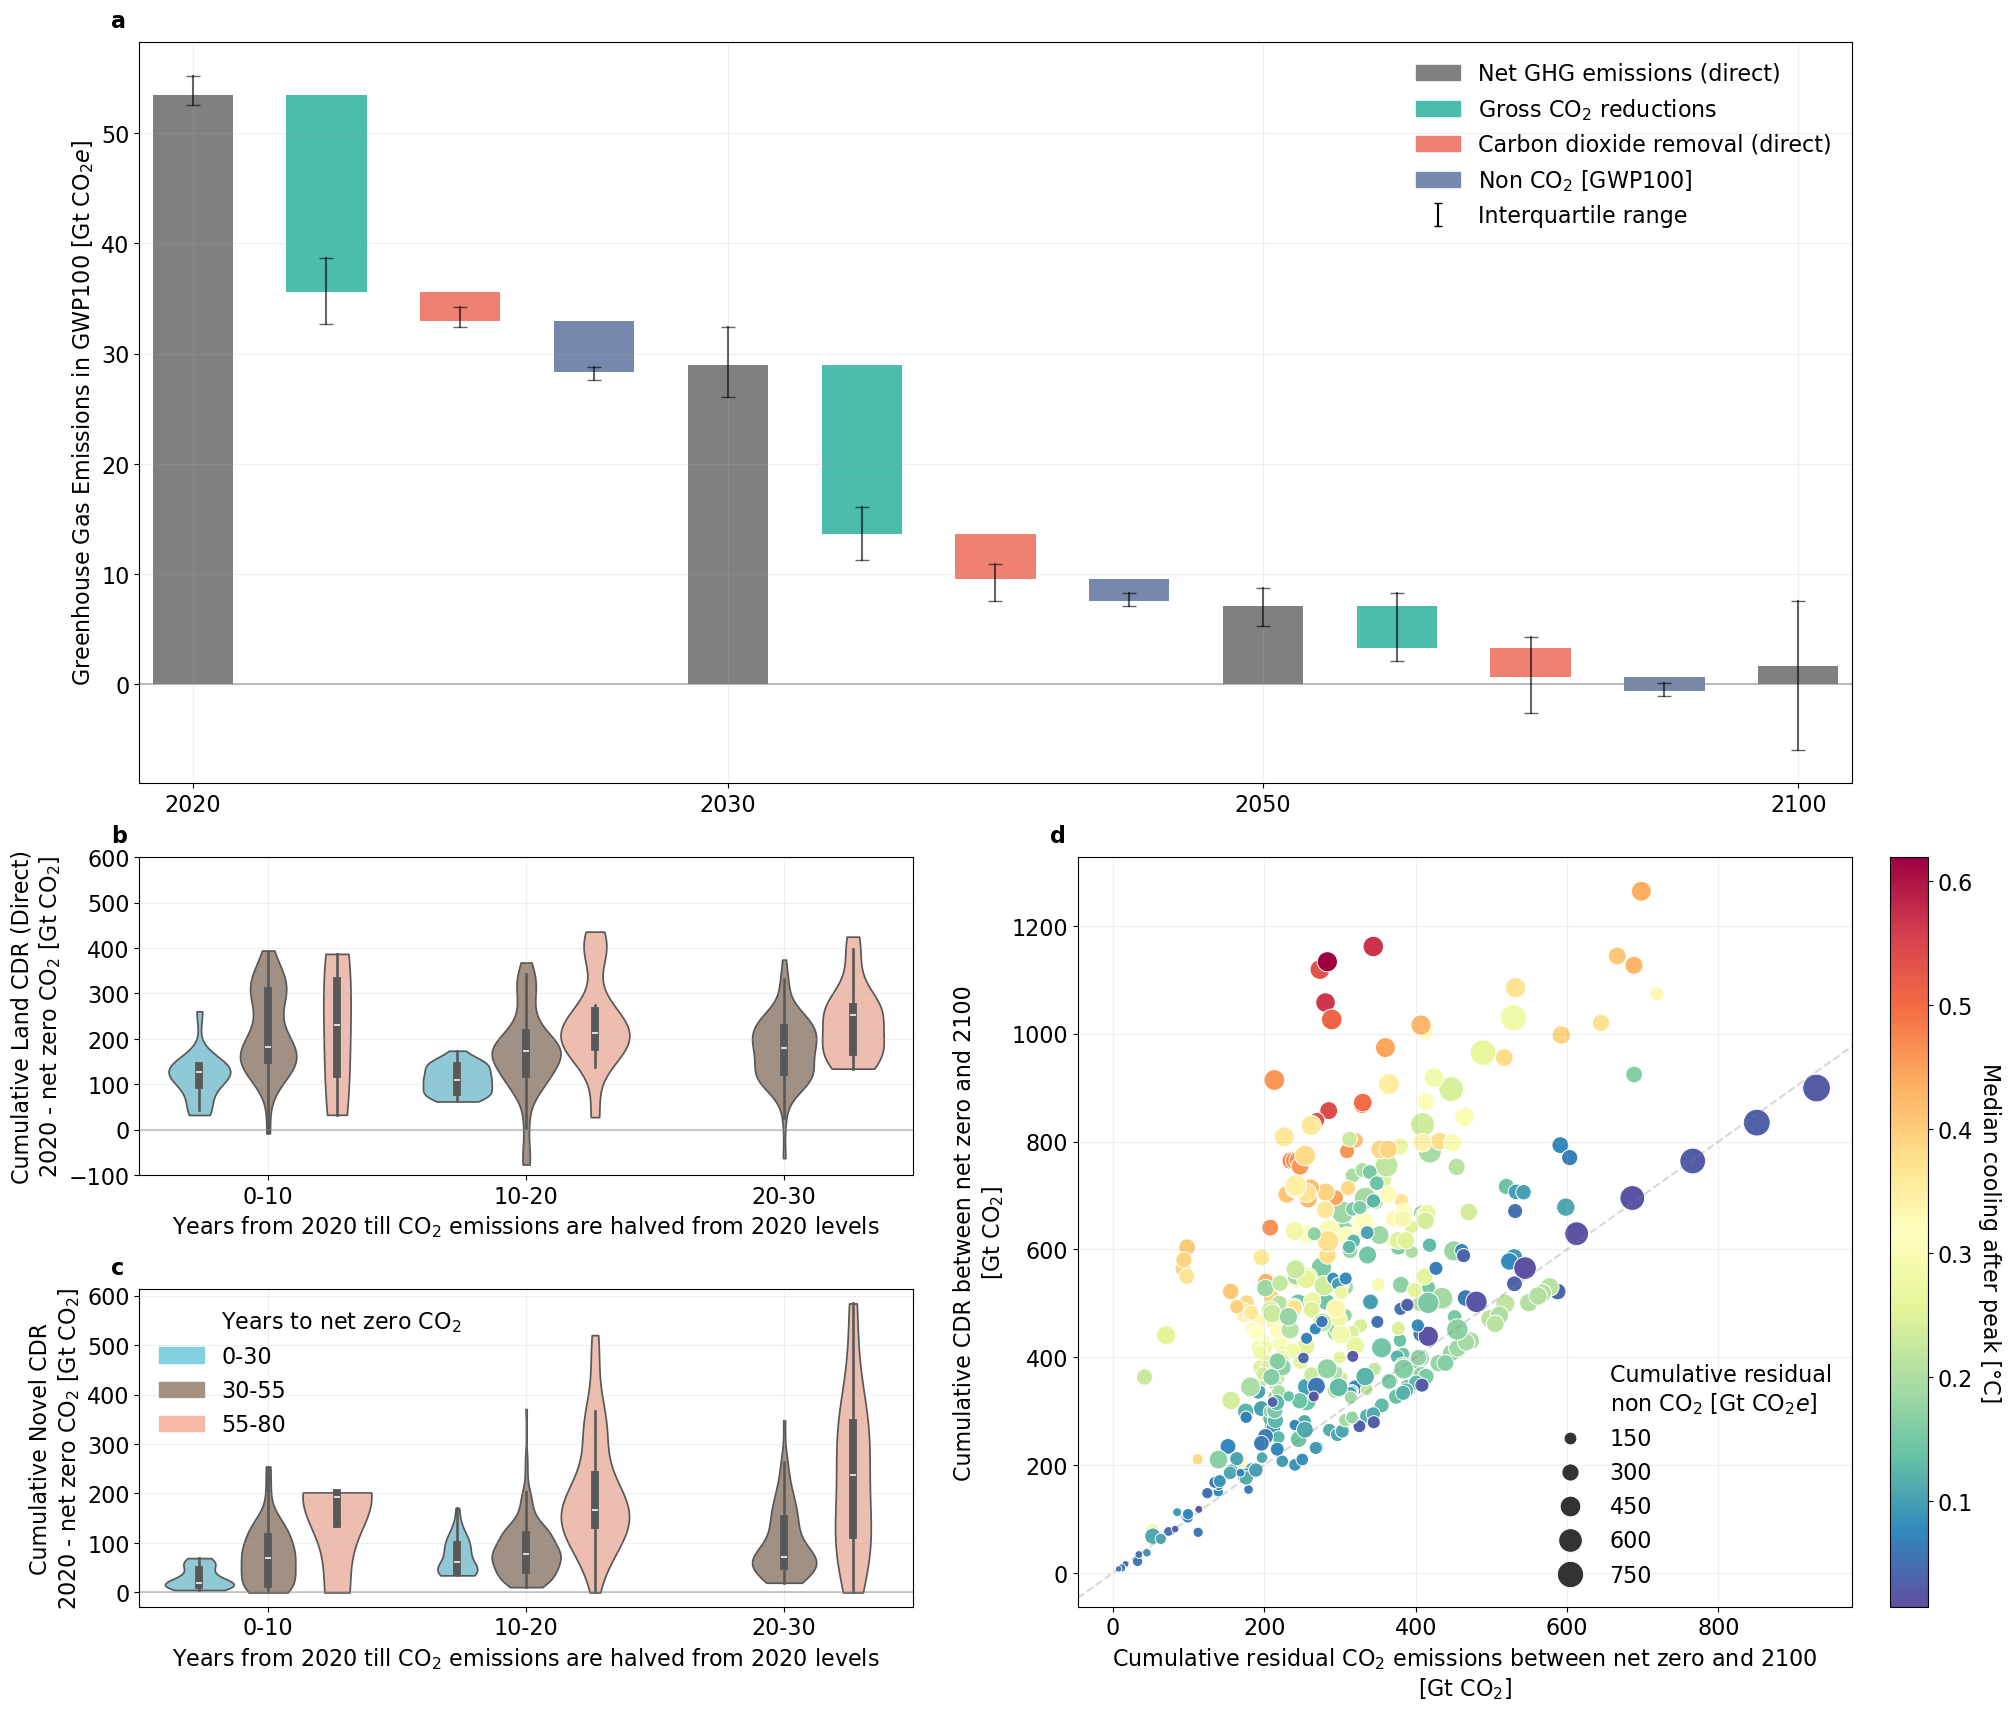

In [33]:
fig, ax = plt.subplot_mosaic(
    [
        ['a', 'a'],
        ['a', 'a'],
        ['b', 'd'],
        ['c', 'd']
    ],
    figsize=(20,17),
    constrained_layout=True
)

# PANEL A
plot_waterfall_reductions(
    ax=ax['a'],
    climate_category='C1'
)
ax['a'].set_ylabel('Greenhouse Gas Emissions in GWP100 [Gt CO$_2e$]')

# PANEL B
b = sns.violinplot(
    data=panel_bc,
    x='category_reductions',
    y='land_cdr_2020_netzero',
    ax=ax['b'],
    hue='category_netzero',
    cut=0,
    palette=[
        '#83d0e2',
        '#a5917f',
        '#f7b9a6'
    ],
    legend=False

)
b.set_xlabel('Years from 2020 till CO$_2$ emissions are halved from 2020 levels')
b.set_ylabel('Cumulative Land CDR (Direct)\n2020 - net zero CO$_2$ [Gt CO$_2$]')
ax['b'].axhline(0, color='grey', alpha=0.4)
ax['b'].set_ylim(-100, 600)

# PANEL C
c = sns.violinplot(
    data=panel_bc,
    x='category_reductions',
    y='novel_cdr_2020_netzero',
    ax=ax['c'],
    hue='category_netzero',
    palette=[
        '#83d0e2',
        '#a5917f',
        '#f7b9a6'
    ],
    cut=0,
    legend=False
)
c.set_xlabel('Years from 2020 till CO$_2$ emissions are halved from 2020 levels')
c.set_ylabel('Cumulative Novel CDR\n2020 - net zero CO$_2$ [Gt CO$_2$]')
ax['c'].axhline(0, color='grey', alpha=0.4)

second_custom_legend = [
    Patch(facecolor='w', edgecolor='w', label='Years to net zero CO$_2$'),
    Patch(facecolor='#83d0e2', edgecolor='#83d0e2', label='0-30'),
    Patch(facecolor='#a5917f', edgecolor='#a5917f', label='30-55'),
    Patch(facecolor='#f7b9a6', edgecolor='#f7b9a6', label='55-80'),
]
ax['c'].legend(handles=second_custom_legend, framealpha=0.0, ncol=1)

# PANEL D
d = sns.scatterplot(
    data=panel_d,
    ax=ax['d'],
    x='cumulative_gross_netzero_2100',
    y='cumulative_cdr_netzero_2100',
    hue='t_decline',
    size='cumulative_nonco2_netzero_2100',
    palette='Spectral_r',
    sizes=(20, 400)
)

norm = plt.Normalize(
    panel_d['t_decline'].min(),
    panel_d['t_decline'].max()
)
sm = plt.cm.ScalarMappable(cmap="Spectral_r", norm=norm)
cbar = d.figure.colorbar(sm, ax=ax['d'])
cbar.ax.set_ylabel('Median cooling after peak [°C]', rotation=270, labelpad=20) 
ax['d'].axline((0, 0), (1, 1),color='grey', linestyle='dashed', alpha=0.3)
ax['d'].set_xlabel('Cumulative residual CO$_2$ emissions between net zero and 2100\n[Gt CO$_2$]')
ax['d'].set_ylabel('Cumulative CDR between net zero and 2100\n[Gt CO$_2$]')

h, l = d.get_legend_handles_labels()
#l[7] = 'Cumulative\ngross CO$_2$'
l[5] = 'Cumulative residual\nnon CO$_2$ [Gt CO$_2e$]'
ax['d'].legend(h[5:], l[5:], ncol=1, framealpha=0.0, loc=4)

# Handle grids and annotations for subplots
for lab,a in ax.items():
    a.grid(alpha=0.2)
    trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
    a.text(0.0, 1.0, lab, transform=a.transAxes + trans,
             va='bottom', weight='bold')

In [34]:
fig.savefig(
    Path(
        'figures/fig1_final.png'
    ),
    dpi=400,
    bbox_inches='tight'
)

Now, we want to create a supplementary figure with the C2 and C3 categories to be referenced in the main text.

Text(0, 0.5, 'Greenhouse Gas Emissions in GWP100 [Gt CO$_2e$]')

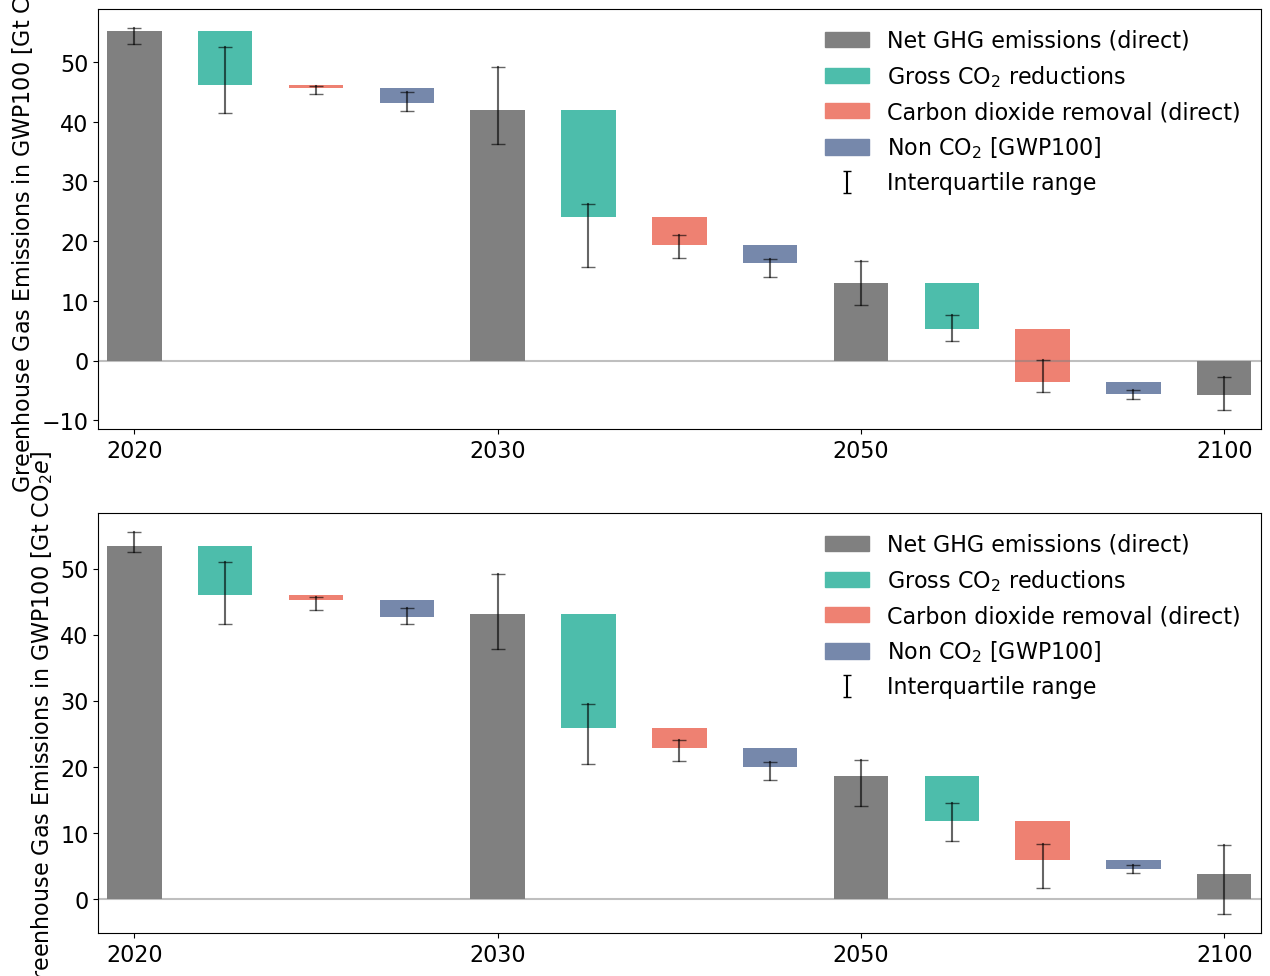

In [35]:
fig_si, ax_si = plt.subplot_mosaic(
    [
        ['a'],
        ['b']
    ],
    figsize=(15, 12)
)

# PANEL A
plot_waterfall_reductions(
    ax=ax_si['a'],
    climate_category='C2'
)

# PANEL A
plot_waterfall_reductions(
    ax=ax_si['b'],
    climate_category='C3'
)
ax_si['a'].set_ylabel('Greenhouse Gas Emissions in GWP100 [Gt CO$_2e$]')
ax_si['b'].set_ylabel('Greenhouse Gas Emissions in GWP100 [Gt CO$_2e$]')

In [36]:
stats = pyam.Statistics(
    df=df.filter(region='World'),
    filters=[
        ('C1', {'Category':'C1'}),
        ('C2', {'Category':'C2'}),
        ('C3', {'Category':'C3'})
    ],
    rows=True
)

In [37]:
compare_years = [
    (2020, 2030),
    (2020, 2035),
    (2020, 2050),
    (2020, 2100)
]

In [38]:
statistics_settings = dict(
    header='Level [Gt CO2]',
    header_change='Change from 2020',
    header_percent_change='% change from 2020',
    compare_years=compare_years,
    years=[2020, 2030, 2035, 2050, 2100]
)

Add a helper function to add the necessary statstics.

In [39]:
def add_statistics(data, row,years, compare_years,header, header_change, header_percent_change):
    stats.add(
        data[years],
        header=header,
        row=row
    )
    for i,j in compare_years:
        change = (data[j] - data[i])
        percent_change = (data[j] - data[i]) * 100 / data[i]
        #stats.add(
        #    change,
        #    header=header_change,
        #    row=row,
        #    subheader=f'{i}-{j}'
        #)
        stats.add(
            percent_change,
            header=header_percent_change,
            row=row,
            subheader=f'{i}-{j}'
        )

In [40]:
df.variable

['AR6 Reanalysis|OSCARv3.2|Carbon Removal',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Direct',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Indirect',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Non-Land',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Total',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU|Direct',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU|Indirect',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Direct Only',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Gross',
 'AR6 Reanalysis|OSCARv3.2|Emissions|Kyoto Gases',
 'AR6 Reanalysis|OSCARv3.2|Emissions|Kyoto Gases|Direct Only',
 'AR6 Reanalysis|OSCARv3.2|Emissions|NonCO2|Direct Only',
 'Population']

In [41]:
variable_label = [
    ('AR6 Reanalysis|OSCARv3.2|Emissions|Kyoto Gases|Direct Only', 'Net GHG (direct)'),
    ('AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Gross', 'Gross CO2 (direct)'),
    ('AR6 Reanalysis|OSCARv3.2|Emissions|NonCO2|Direct Only', 'Non CO2'),
    ('AR6 Reanalysis|OSCARv3.2|Carbon Removal|Total', 'CDR (direct)')
]

In [42]:
for var, label in variable_label:
    data = (
        df
        .filter(
            variable=var,
            region='World'
        )
        .timeseries()
    )
    add_statistics(
        data,
        label,
        **statistics_settings
    )

/Users/gauravganti/anaconda3/envs/ar6_cdr_assessment/lib/python3.10/site-packages/pyam/statistics.py:201: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  _stats = _stats_f if _stats is None else _stats.append(_stats_f)
/Users/gauravganti/anaconda3/envs/ar6_cdr_assessment/lib/python3.10/site-packages/pyam/statistics.py:201: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  _stats = _stats_f if _stats is None else _stats.append(_stats_f)
/Users/gauravganti/anaconda3/envs/ar6_cdr_assessment/lib/python3.10/site-packages/pyam/statistics.py:201: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  _stats = _stats_f if _stats is None else _stats.append(_stats_f)
/Users/gauravganti/anaconda3/envs/ar6_cdr_assessment/lib/python3.10/site-packages/

In [43]:
numbers = (
    stats
    .summarize(
        center='median',
        interquartile=True,
        custom_format='{:.1f}'
    )
    .round(1)
    #.swaplevel(0,1, axis=0)
    #.sort_index(level=0)
)


In [44]:
numbers

count     Level [Gt CO2]                     \
median (interquartile range)                     2020               2030   
C1 Net GHG (direct)             70  53.4 (55.2, 52.6)  28.9 (32.4, 26.0)   
   Gross CO2 (direct)           70  41.8 (43.7, 40.0)  24.5 (26.2, 21.1)   
   Non CO2                      70  14.8 (15.2, 14.0)    9.8 (10.8, 9.3)   
   CDR (direct)                 70     2.5 (2.5, 2.5)     5.1 (5.7, 3.9)   
C2 Net GHG (direct)            106  55.2 (55.7, 53.1)  42.0 (49.1, 36.2)   
   Gross CO2 (direct)          106  43.3 (43.9, 40.7)  33.7 (39.4, 28.4)   
   Non CO2                     106  14.2 (15.2, 13.8)  11.9 (13.3, 10.7)   
   CDR (direct)                106     2.5 (2.5, 2.5)     3.1 (4.0, 2.8)   
C3 Net GHG (direct)            231  53.4 (55.5, 52.5)  43.1 (49.1, 37.8)   
   Gross CO2 (direct)          231  42.1 (43.7, 40.0)  34.0 (39.0, 30.7)   
   Non CO2                     231  14.7 (15.3, 14.0)  12.3 (13.2, 11.0)   
   CDR (direct)                231     2.5 (2.5, 2.5)     3.2 (4.7, 2.7)   

                                                                    \
median (interquartile range)               2035               2050   
C1 Net GHG (direct)           21.1 (24.2, 18.5)     7.2 (8.7, 5.3)   
   Gross CO2 (direct)         18.1 (20.6, 16.1)    8.3 (10.1, 7.5)   
   Non CO2                       9.0 (9.9, 8.4)     7.6 (8.9, 6.7)   
   CDR (direct)                  6.1 (7.1, 4.9)    9.3 (11.5, 7.6)   
C2 Net GHG (direct)           31.8 (36.9, 28.1)   13.0 (16.7, 9.3)   
   Gross CO2 (direct)         26.4 (29.7, 22.7)  12.8 (16.5, 10.8)   
   Non CO2                     10.1 (10.9, 9.4)     8.3 (9.2, 7.7)   
   CDR (direct)                  4.4 (5.6, 3.4)    8.0 (10.5, 6.6)   
C3 Net GHG (direct)           34.5 (37.6, 29.6)  18.6 (21.1, 14.1)   
   Gross CO2 (direct)         28.1 (30.3, 24.9)  16.2 (18.3, 13.9)   
   Non CO2                     10.5 (11.4, 9.3)     8.6 (9.2, 7.3)   
   CDR (direct)                  4.1 (5.5, 3.2)     6.3 (9.4, 5.5)   

                                                   % change from 2020  \
median (interquartile range)               2100             2020-2030   
C1 Net GHG (direct)             1.7 (7.6, -5.9)  -47.5 (-38.9, -51.6)   
   Gross CO2 (direct)           5.5 (11.7, 3.9)  -43.1 (-35.3, -49.7)   
   Non CO2                       6.6 (7.6, 5.3)  -31.8 (-28.6, -35.1)   
   CDR (direct)                11.8 (17.1, 9.5)   105.7 (125.0, 56.5)   
C2 Net GHG (direct)           -5.8 (-2.7, -8.3)   -23.2 (-8.9, -34.2)   
   Gross CO2 (direct)            5.3 (7.7, 3.9)   -21.0 (-6.6, -33.1)   
   Non CO2                       6.1 (7.0, 5.0)   -17.3 (-4.9, -26.6)   
   CDR (direct)               17.7 (20.3, 14.1)     23.5 (61.8, 11.3)   
C3 Net GHG (direct)             3.7 (8.1, -2.3)   -20.2 (-7.5, -29.6)   
   Gross CO2 (direct)           8.5 (12.6, 6.8)   -17.7 (-6.0, -28.3)   
   Non CO2                       6.8 (7.7, 5.4)   -18.4 (-8.2, -24.3)   
   CDR (direct)               13.5 (17.4, 10.1)     29.1 (84.8, 10.9)   

                                                                          \
median (interquartile range)             2020-2035             2020-2050   
C1 Net GHG (direct)           -61.7 (-55.2, -64.9)  -86.8 (-83.8, -90.0)   
   Gross CO2 (direct)         -56.2 (-50.1, -61.6)  -79.4 (-76.0, -82.1)   
   Non CO2                    -36.9 (-34.4, -42.4)  -47.3 (-40.4, -53.8)   
   CDR (direct)                142.6 (181.6, 93.4)  268.5 (354.9, 200.5)   
C2 Net GHG (direct)           -41.0 (-32.8, -49.6)  -75.9 (-70.5, -83.0)   
   Gross CO2 (direct)         -37.1 (-28.8, -47.0)  -70.1 (-62.2, -74.5)   
   Non CO2                    -31.2 (-24.3, -36.1)  -43.6 (-38.1, -46.8)   
   CDR (direct)                 77.9 (119.3, 33.4)  224.2 (305.4, 165.3)   
C3 Net GHG (direct)           -36.3 (-30.6, -46.0)  -65.8 (-61.5, -73.7)   
   Gross CO2 (direct)         -33.0 (-27.0, -40.2)  -61.3 (-55.4, -67.4)   
   Non CO2                    -27.4 (-22.4, -39.

In [45]:
numbers.to_excel(
    Path(
        'figures/table1.xlsx'
    )
)

Statements: The contributions of non CO2 reductions and CDR between:
* 2030 - 2035 and
* 2035 - 2050

In [46]:
net_emissions = (
    compiled_data_magnitude
    .filter(
        variable='AR6 Reanalysis|OSCARv3.2|Emissions|Kyoto Gases|Direct Only'
    )
    .timeseries()
)

In [47]:
start_end = [
    (2020, 2030),
    (2030, 2050)
]

In [48]:
for start, end in start_end:
    compiled_data_magnitude.set_meta(
        name=f'total_mitigation_{start}_{end}',
        meta=net_emissions[end] - net_emissions[start]
    )

In [49]:
compiled_data_magnitude.variable

['AR6 Reanalysis|OSCARv3.2|Carbon Removal',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Direct',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Indirect',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Non-Land',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Total',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Direct Only',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Gross',
 'AR6 Reanalysis|OSCARv3.2|Emissions|Kyoto Gases|Direct Only',
 'AR6 Reanalysis|OSCARv3.2|Emissions|NonCO2|Direct Only']

In [50]:
vars_of_interest = [
    ('AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Gross', 'gross'),
    ('AR6 Reanalysis|OSCARv3.2|Emissions|NonCO2|Direct Only', 'nonco2'),
    ('AR6 Reanalysis|OSCARv3.2|Carbon Removal|Total', 'cdr')
]

In [51]:
for start, end in start_end:
    for var, meta_label in vars_of_interest:
        ts = (
            compiled_data_magnitude
            .filter(
                variable=var
            )
            .offset(year=start)
            .timeseries()
        )
        proportion = ts.apply(
            lambda x: x[end] * 100 / (compiled_data_magnitude.meta.loc[x.name[0:2], f'total_mitigation_{start}_{end}']),
            axis=1
        )

        compiled_data_magnitude.set_meta(
            meta=proportion.round(0),
            name=f'{meta_label}_{start}_{end}'
        )

In [52]:
(
    compiled_data_magnitude
    .meta.groupby('Category')
    [['gross_2020_2030', 'nonco2_2020_2030', 'cdr_2020_2030', 'gross_2030_2050', 'nonco2_2030_2050', 'cdr_2030_2050']]
    .describe()
    .T
    .loc[
        pd.IndexSlice[:, ['25%', '50%', '75%']],
        :
    ]
    .unstack()
    .round(0)
)

Category            C1                C2                C3            
                   25%   50%   75%   25%   50%   75%   25%   50%   75%
gross_2020_2030   64.0  70.0  77.0  61.0  72.0  78.0  52.0  64.0  75.0
nonco2_2020_2030  16.0  20.0  24.0  16.0  19.0  26.0  18.0  25.0  31.0
cdr_2020_2030      5.0  10.0  14.0   3.0   6.0  12.0   2.0   8.0  15.0
gross_2030_2050   63.0  68.0  74.0  64.0  71.0  75.0  64.0  73.0  78.0
nonco2_2030_2050   6.0   9.0  12.0  10.0  13.0  14.0  11.0  14.0  16.0
cdr_2030_2050     14.0  20.0  31.0  12.0  18.0  24.0   8.0  14.0  22.0

In [53]:
variable_label = [
    ('AR6 Reanalysis|OSCARv3.2|Emissions|Kyoto Gases|Direct Only', 'Net GHG (direct)'),
    ('AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Gross', 'Gross CO2 (direct)'),
    ('AR6 Reanalysis|OSCARv3.2|Emissions|NonCO2|Direct Only', 'Non CO2'),
    ('AR6 Reanalysis|OSCARv3.2|Carbon Removal|Total', 'CDR (direct)')
]

In [54]:
panel_bc.loc[:, 'cdr_2020_netzero'] = (
    panel_bc.loc[:, 'land_cdr_2020_netzero']
    +
    panel_bc.loc[:, 'novel_cdr_2020_netzero']
)

Let us first take a look at the effect of net zero delay.

In [55]:
(
    panel_bc
    .groupby('category_netzero')[
        [
            'cdr_2020_netzero',
            'land_cdr_2020_netzero',
            'novel_cdr_2020_netzero'
        ]
    ]
    .describe()
    .loc[
        :,
        pd.IndexSlice[:, ['25%', '50%', '75%']]
    ]
    .round(0)
)

cdr_2020_netzero               land_cdr_2020_netzero         \
                              25%    50%    75%                   25%    50%   
category_netzero                                                               
0-30                        149.0  166.0  193.0                  83.0  114.0   
30-55                       203.0  251.0  319.0                 130.0  174.0   
55-80                       345.0  423.0  539.0                 174.0  214.0   

                        novel_cdr_2020_netzero                
                    75%                    25%    50%    75%  
category_netzero                                              
0-30              141.0                   37.0   48.0   80.0  
30-55             223.0                   48.0   76.0  122.0  
55-80             272.0                  132.0  182.0  305.0

In [56]:
(
    panel_bc
    .groupby('category_reductions')[
        [
            'cdr_2020_netzero',
            'land_cdr_2020_netzero',
            'novel_cdr_2020_netzero'
        ]
    ]
    .describe()
    .loc[
        :,
        pd.IndexSlice[:, ['25%', '50%', '75%']]
    ]
    .round(0)
)

cdr_2020_netzero               land_cdr_2020_netzero  \
                                 25%    50%    75%                   25%   
category_reductions                                                        
0-10                           154.0  184.0  390.0                 129.0   
10-20                          195.0  250.0  349.0                 117.0   
20-30                          243.0  297.0  358.0                 136.0   

                                  novel_cdr_2020_netzero               
                       50%    75%                    25%   50%    75%  
category_reductions                                                    
0-10                 159.0  275.0                   15.0  56.0   98.0  
10-20                171.0  215.0                   53.0  85.0  133.0  
20-30                185.0  236.0                   57.0  93.0  176.0

Finally, let us calculate the post net zero CO2 shares.

In [57]:
compiled_data_magnitude.meta.loc[:, 'share_novel_cdr_netzero_2100'] = (
    (compiled_data_magnitude.meta.loc[:, 'novel_cdr_netzero_2100']) *100
    /
    (compiled_data_magnitude.meta.loc[:, 'novel_cdr_netzero_2100']+df.meta.loc[:, 'land_cdr_netzero_2100'])
)

In [58]:
ix_to_change = compiled_data_magnitude.meta[compiled_data_magnitude.meta['land_cdr_netzero_2100']<0].index
compiled_data_magnitude.meta.loc[ix_to_change, 'share_novel_cdr_netzero_2100'] = 100

In [59]:
(
    compiled_data_magnitude
    .meta
    .groupby('Category')['share_novel_cdr_netzero_2100']
    .describe()
    .round(0)
)

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
C1,70.0,59.0,19.0,0.0,48.0,62.0,72.0,90.0
C2,106.0,71.0,12.0,48.0,60.0,68.0,81.0,100.0
C3,217.0,68.0,16.0,0.0,58.0,68.0,78.0,100.0


Further statements: novel CDR level in 2050 for the C1 category of pathways.

In [60]:
compiled_data_magnitude.set_meta_from_data(
    variable='AR6 Reanalysis|OSCARv3.2|Carbon Removal|Non-Land',
    year=2050,
    region='World',
    name='novel_cdr_2050'
)

In [61]:
(
    compiled_data_magnitude
    .meta
    .groupby(
        ['Category']
    )['novel_cdr_2050']
    .describe()
    .round(0)
) * -1

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
C1,-70.0,5.0,-3.0,15.0,6.0,4.0,2.0,0.0
C2,-106.0,4.0,-3.0,16.0,6.0,4.0,2.0,1.0
C3,-231.0,3.0,-2.0,11.0,4.0,2.0,1.0,0.0


Final statements on this one: we want to know the contribution of gross CO2 cuts to total mitigation at net zero CO2.

In [62]:
(
    compiled_data_magnitude
    .meta
    .loc[:, 'Year of netzero CO2 emissions (Harm-Infilled) table']
    .fillna(2100, inplace=True)
)

Now, let us pull out the netzero years from the meta data.

In [63]:
netzero_years = compiled_data_magnitude.meta['Year of netzero CO2 emissions (Harm-Infilled) table']


We want to calculate the total mitigation at the year of net zero CO2.

In [64]:
total_mitigation_variable = 'AR6 Reanalysis|OSCARv3.2|Emissions|Kyoto Gases|Direct Only'

In [65]:
total_mitigation_values = (
    compiled_data_magnitude
    .filter(variable=total_mitigation_variable)
    .offset(year=2020)
    .timeseries()
)

In [66]:
netzero_years.loc[('AIM/CGE 2.0','SSP1-26')]

2090.0

In [67]:
total_mitigation_at_net_zero = (
    total_mitigation_values
    .apply(
        lambda x: x[netzero_years[x.name[0:2]]],
        axis=1
    )
)

In [68]:
total_mitigation_at_net_zero = (
    total_mitigation_at_net_zero
    .droplevel(
        [
            'region',
            'variable',
            'unit'
        ]
    )
)

Now, pull out the corresponding values of the mitigation from gross CO2 emissions.

In [69]:
gross_emission_variable = 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Gross'

In [70]:
gross_emission_offset_values = (
    compiled_data_magnitude
    .filter(variable=gross_emission_variable)
    .offset(year=2020)
    .timeseries()
)

In [71]:
gross_emission_offset_values_at_net_zero = (
    gross_emission_offset_values
    .apply(
        lambda x: x[netzero_years[x.name[0:2]]],
        axis=1
    )
)

In [72]:
compiled_data_magnitude.set_meta(
    meta = (
        gross_emission_offset_values_at_net_zero * 100 / total_mitigation_at_net_zero
    ),
    name='proportion_gross_emissions_at_net_zero'
)

Get the statistics for the proportions

In [73]:
(
    compiled_data_magnitude
    .meta
    .groupby('Category')['proportion_gross_emissions_at_net_zero']
    .describe()
    .round(0)
)

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
C1,70.0,70.0,7.0,55.0,66.0,71.0,74.0,86.0
C2,106.0,68.0,7.0,36.0,63.0,71.0,73.0,77.0
C3,231.0,66.0,8.0,40.0,59.0,69.0,71.0,86.0


Next, we want to repeat the same procedure for the CDR contribution.

In [74]:
cdr_variable = 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Total'

In [75]:
cdr_offset_values = (
    compiled_data_magnitude
    .filter(variable=cdr_variable)
    .offset(year=2020)
    .timeseries()
)

In [76]:
cdr_offset_values_at_net_zero = (
    cdr_offset_values
    .apply(
        lambda x: x[netzero_years[x.name[0:2]]],
        axis=1
    )
)

In [77]:
compiled_data_magnitude.set_meta(
    meta = (
        cdr_offset_values_at_net_zero * 100 / total_mitigation_at_net_zero
    ),
    name='proportion_cdr_at_net_zero'
)

(
    compiled_data_magnitude
    .meta
    .groupby('Category')['proportion_cdr_at_net_zero']
    .describe()
    .round(0)
)

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
C1,70.0,16.0,7.0,-1.0,12.0,15.0,21.0,28.0
C2,106.0,18.0,7.0,8.0,13.0,17.0,24.0,47.0
C3,231.0,19.0,7.0,-2.0,13.0,17.0,25.0,46.0
